In [1]:
import sys

if "google.colab" in sys.modules:
  !pip install eli5
  !pip install pandas-profiling==2.*
  !pip install pdpbox
  !pip install category_encoders==2.*
  !pip install --upgrade xgboost

import xgboost
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 2.1 MB/s 
     |████████████████████████████████| 133 kB 29.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=cfa79abbe772103754f303575346122684eb6fb53d034a435f19290a4f1cbcc7
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 47 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score
from pdpbox.pdp import pdp_isolate, pdp_plot

In [3]:
from google.colab import files
uploaded = files.upload()

Saving SpotifyFeatures.csv to SpotifyFeatures.csv


In [21]:
df = pd.read_csv('SpotifyFeatures.csv')

In [22]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [23]:
df.shape

(232725, 18)

## *SECTION 2   PROJECT*
---
<br>

## 🏴 **프로젝트 구성**

- **Part 0. Opening**  
  0-1. Planning background <br>
  0-2. Data Description <br>

- **Part 1. EDA** <br>
  1-1. skipped steps <br>
  1-2. Data preprocessing <br>
  1-3. Dataset split

- **Part 2. Data Analysis**  <br>
  2-0. modeling<br>
  2-1. learning<br>
  2-2. validation<br>
  2-3. predictation

- **Part 3. Questions & Insight**<br>
  3-1. development planning

# **Part 0. Opening**

<img width='500' src='https://i.imgur.com/FVgYyRU.jpeg'>


## **0-1. Planning background**

얼마전 길가던중 우연히 재즈풍의 마음에 드는 노래를 찾기 위해 장르 검색으로 뒤져봤는데 안나오더라. <br>
한주 뒤 그 가게앞에서 같은 노래를 듣고 가사로 검색해봤더니 <br>멜로딕랩 요소가 조금 들어가있다고 랩이라고 분류하더라.
이게 말이나 되는거냐고! <br>


아무튼, 음악의 장르와 기준에 대해 음악애호가라면 누구나 갖는 의문점을 갖기 마련이다. <br>
심지어 평론가들조차 하나의 곡에 대해 명확하게 같은 장르로 분류하지 못한다. <br>


사실 음악적 관점에서 보면 여러가지 이유가 있다.<br>
사람의 인지(청각) 자원은 한계가 있기 때문에 **듣고싶은 음악적 요소에 집중**하게 된다.<br>
이때문에 사람마다 곡조를 <u>다르게 듣고, 다르게 해석</u>하게 된다.   <br> 또한, 각 장르가 유행하던 시대가 지나감에 따라 **경계가 모호**해지는 문제도 있다.<br>
도전적인 작곡가들이 많은 <u>장르들을 섞거나 재해석</u>하기 때문이다.  <br>

결국 장르라는 구분은 사람들이 세우고 사람들이 판단하기에 모호한것 아닐까? <br>
이런 생각을 하던 나에게, 마침 두달 동안 AI의 힘을 빌려 분석해볼 지식을 쌓을 기회가 주어졌다! <br>
과연 **AI는 어떤 음악적 요소에 따라 장르에 대해 분류** 하고 더 나아가, 나에게 **음악을 추천**해줄 수 있을까?<br>



#  **❌ Notice in Advance ❌**<br>
타겟인 장르(jenre) 정보를 각종 음원사이트에서 크롤링 해 오는 것부터 많은 시행착오를 겪었고, <br>
익숙하지 않은 라이브러리와 그에 맞는 환경을 다루면서(vscode + anaconda 환경구축, librosa library 등) <br> 수 많은 오류를 해결하느라 이틀이 넘는 시간을 쓴 탓에 하루 남짓한 시간으로 결과를 내기 위해 <br>데이터의 양이나 품질이 떨어지더라도  학습에 사용하기로 결정 했습니다.<br>

**데이터는 크롤링을 배우고, 코딩실력을 늘려가면서 차후 늘려가는 것으로 방향을 잡고  <br>
이번에는 학습과정을 보이기 위한 프로젝트로 삼겠습니다.**<br>

*※ 진행중이던 프로젝트는 서브디렉토리에 포함시켰습니다.*


## **0-2. Data Description**

`data source`<br>

https://www.kaggle.com/code/iqbalbasyar/spotify-genre-classification/data

`Features:` 

- genre = 곡의 장르 (target)
- artist_name = 아티스트명
- track_name = 곡명
- track_id = 곡의 고유식별코드(spotify database 접근 키)
- popularity = 잘 알려진 노래인지?
- acousticness = 어쿠스틱성향(전자음향이 포함되지 않은 정도)
- danceability = 춤과 어울리는 정도(템포, 리듬안정성(템포 변화가 적은정도), 비트 강도(박자의 인지정도) 등의 복합적수치) 
- duration_ms = 재생시간(단위:ms)
- energy = 활동적 성향(음량변화, 조성변화, 세션의 참여도 등으로 수치화된 책정된 곡조의 에너지틱 성향)
- instrumentalness = 보컬의 비중(세션대비 보컬의 음량 / 믹싱단계에서 설정한 보컬의 음량밸런스)
- key = 트랙의 주선율 피치(조성표기법). 
- liveness = 라이브음원일 확률(ZCR, 하울링, 공진(넓은스테이지), 관객의 소리 등을 수치화)
- loudness = 시끄러운 정도(데시빌(dB) 단위로 측정된 전체트랙의 평균음량)
- mode = 주선율의 조성(Maj/min)
- speechiness = 음성기반 자연어 인식 비중(높을수록 보컬의 공백이 없음, 낮을수록 기악에 가까움)
- tempo = 곡의 템포(BPM)
- time_signature = 소절당 비트수(ex, 3/4박자일경우 3회)
- valence = 곡조의 밝음(긍정적인 감성의 정도)

In [24]:
df[df.duplicated()] # 중복없음

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


In [25]:
df = df.reset_index(drop=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

> **⏭ Result**<br>
분석결과 중복되지 않은 총 <U>**232725개**</U> Title에 대한 데이터로,<br>
초기 목표로 했던 각종 음향 정보가 포함되어 있지 않고, <br> 출처와 산출기준이 불분명한 특성(danceability, energy, valence 등)이 포함되어있으나, <br> 데이터의 출처(kaggle이나, 원본데이터는 spotify 제공)가 신뢰할 수 있고, <br>
데이터셋이 Target인 '장르'에 대해 다루고 있으며, 타겟에 결측치가 없으며<br>
데이터 자체의 양이 많아서 유의미한 결과를 도출해낼 수 있을것으로 판단함. <br>

# **Part 1. EDA**


## **1-1. skipped steps**
> ⚠️***Missing value handling*** <br>
> ⚠️***Feature Engineering*** <br>
         

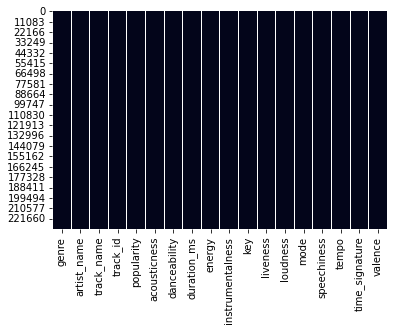

In [27]:
%matplotlib inline
sns.heatmap(df.isnull(), cbar=False) #결측치 시각화 = 결측치 없음

> **💡 why skipped?**  
> - **Missing value handling** <br>
→ 대형 미디어 서비스 회사인 spotify에서 무결성 확인후 개발자환경을 통해 제공 .<br>
> - **Feature Engineering** <br>
→ 특성들이 대부분 추상적( *1) 이거나, 산출공식이나 기준을 알 수 없는 복합적( *2)인 수치이므로 <br>
특성간 연산을 통해 설명력의 손실이나, 특성중요도가 감소할 가능성이 있다고 판단해서 건너뜀.<br>
  *1) danceability, energy, valence<br>
  *2) popularity, instrumentalness, liveness, speechiness<br>

## **1-2. Data preprocessing**
> ⚠️***모델에 학습시키기 전 착안사항에 중점을 두고 판단함.***

In [28]:
df.head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [29]:
df.genre.value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [30]:
df.genre = df.genre.replace("Children’s Music", "Children's Music") # 따옴표를 어퍼스트로피로 변환

> **💡 Decision**  
> - **일부 장르 제외** <br>
→ 장르(target)의 갯수가 많으면 분류 정확도가 떨어질 것으로 예상 <br>
→ 장르의 대표성이 모호하거나 설명력이 부족한 일부 장르 제외<br>

> **❌ Drop data**  
> - **종합미디어장르** <U>※ 음악성이 다양한 종속적 장르</U> <br>
  - Soundtrack <br>
  - Anime<br>
  - Movie
> - **로컬음악** <U>※ 범장르적이거나 다양한 나라의 음악이라 특성이 정형화되기 힘듬</U>
  - alternative
  - indie
  - World 

> **⭕ Hold**  
> - **파생장르** <U>※관계 유사성 높지만 보류</U> <br>
  - reggaeton - Reggae<br>


In [31]:
other_genre = df[(df['genre'] == 'Soundtrack') | (df['genre'] == 'Anime') | (df['genre'] == 'Movie') | (df['genre'] == 'World') | (df['genre'] == 'Indie') | (df['genre'] == 'Alternative')]
other_genre.shape # 사운드트랙, 애니메이션, 영화, 세계로컬음악

(54290, 18)

In [32]:
df = df.drop(other_genre.index)

In [33]:
len(df.genre.unique()) # 장르 갯수

20

In [34]:
df.genre.value_counts() # 장르별 곡 수

Children's Music    14756
Comedy               9681
Jazz                 9441
Pop                  9386
Electronic           9377
Folk                 9299
Hip-Hop              9295
Rock                 9272
Classical            9256
Rap                  9232
Soul                 9089
Blues                9023
R&B                  8992
Reggaeton            8927
Ska                  8874
Reggae               8771
Dance                8701
Country              8664
Opera                8280
A Capella             119
Name: genre, dtype: int64

In [35]:
df.shape[0]

178435

> **⏭ Result**<br>
장르 갯수는 많으나, 데이터의 수도 <U>178435개</U> 이므로 유의미한 결과가 나올 것으로 예상됨

In [36]:
df.track_id.value_counts() # track_id가 곡의 고유번호인데 중복값이 여러개 나옴.

2zbjlcLi1VQWqDNYdhyx1l    6
21fXrzSxu2y51Yqf57QycI    6
08uGhvS5MfBk7crUCpnjva    6
5CKAdIqcxvpSR4svKpYD8n    6
0725YWm6Z0TpZ6wrNk64Eb    6
                         ..
1zjPdQ3QzNUP5P7Yj5ZedQ    1
1AFTewhYSsDyDAlcg7jpVf    1
0T1fWmay7AeUNVGe7zVC4e    1
761hy35aVvYK1XnWdPMwb6    1
34XO9RwPMKjbvRry54QzWn    1
Name: track_id, Length: 139904, dtype: int64

In [37]:
df[df.track_id == '0wY9rA9fJkuESyYm9uzVK5'] # 6개 중복인 데이터 하나를 대표로 조회함

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
68204,Hip-Hop,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
77892,Children's Music,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,66,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
115551,Rap,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
149893,Pop,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
152677,R&B,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656
192273,Soul,SiR,D'Evils,0wY9rA9fJkuESyYm9uzVK5,67,0.00558,0.784,171818,0.586,0.000286,C#,0.106,-3.417,Major,0.187,132.169,4/4,0.656


> **💡 Decision**  
> - **중복된 track_id를 갖는 데이터 삭제** <br>
→ 살펴본 결과, genre와 popularity를 제외한 모든요소가 같음. 즉, 같은 곡임. <br>
→ 여러 장르에 해당하는(Mixed genre) 곡이거나, 제대로 분류가 되지 않은 이상치 데이터, 둘중 하나임. <br>
    (랩+힙합+동요+소울? = 말도안돼!)<br>

In [38]:
track_id_all = df.track_id.value_counts()
track_id_duplicated = track_id_all[~track_id_all.isin([1])]
track_id_duplicated # 

2zbjlcLi1VQWqDNYdhyx1l    6
21fXrzSxu2y51Yqf57QycI    6
08uGhvS5MfBk7crUCpnjva    6
5CKAdIqcxvpSR4svKpYD8n    6
0725YWm6Z0TpZ6wrNk64Eb    6
                         ..
3DamFFqW32WihKkTVlwTYQ    2
2U2shkjkiZxS5Le7s5R0HE    2
2Y43TDqgnRgVZA7RxtxEV1    2
47Bg6IrMed1GPbxRgwH2aC    2
0Yvyj5YkjSBNgD4Ai0clSG    2
Name: track_id, Length: 27243, dtype: int64

In [39]:
df[df['track_id'].isin(list(track_id_duplicated.index))] # 두개이상의 target을 가지는 mixed target data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
135,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.08300,0.724,246333,0.689,0.000000,D,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930
136,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.32300,0.685,186467,0.610,0.000000,C,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230
137,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.06750,0.762,199520,0.520,0.000004,F,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862
138,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.36000,0.563,240597,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680
139,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.59600,0.653,213947,0.621,0.000000,B,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232715,Soul,Emily King,Down,5cA0vB8c9FMOVDWyJHgf26,42,0.55000,0.394,281853,0.346,0.000002,E,0.1290,-13.617,Major,0.0635,90.831,4/4,0.4360
232718,Soul,Muddy Waters,I Just Want To Make Love To You - Electric Mud...,2HFczeynfKGiM9KF2z2K7K,43,0.01360,0.294,258267,0.739,0.004820,C,0.1380,-7.167,Major,0.0434,176.402,4/4,0.9450
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.9620
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.8130


In [40]:
df[~df['track_id'].isin(list(track_id_duplicated.index))] # 하나의 target만을 가지는 single-target data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
158,R&B,James Blake,Can't Believe The Way We Flow,6voR6zsWIn7vgZYGOFKYSZ,65,0.7050,0.259,267200,0.536,0.000501,G#,0.4320,-10.309,Major,0.0367,143.948,4/4,0.290
173,R&B,Tom Misch,Movie,6pxElwU80zhjbCC77Vn8EI,67,0.3910,0.785,357357,0.379,0.016100,G,0.2670,-11.446,Major,0.0732,122.043,3/4,0.182
219,R&B,Peter CottonTale,Forever Always,4B2kIC5F0kSVfTD5crzgm9,61,0.8520,0.362,215160,0.443,0.000132,D#,0.1380,-6.351,Major,0.0663,54.924,4/4,0.415
222,R&B,James Blake,Are You In Love?,6uYhMShmQkRYbrnOjERpoR,65,0.7230,0.557,197600,0.278,0.000022,G#,0.0755,-12.353,Major,0.0427,147.681,4/4,0.335
234,R&B,James Blake,Power On,5Yq38evNk28qlTVHHtwBhT,65,0.8490,0.649,246400,0.468,0.007060,D,0.1060,-10.951,Major,0.0447,92.489,4/4,0.618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232716,Soul,John Legend,Quickly (feat. Brandy),1U0OMWvR89Cm20vCNar50f,39,0.2310,0.736,222667,0.701,0.000000,A#,0.2030,-4.345,Minor,0.1000,99.991,4/4,0.770
232717,Soul,Belly,P.O.P.,2gGqKJWfWbToha2YmDxnnj,43,0.1040,0.802,201173,0.516,0.000485,D,0.1050,-9.014,Major,0.2130,175.666,4/4,0.482
232719,Soul,"Bobby ""Blue"" Bland",I'll Take Care Of You - Single Version,2iZf3EUedz9MPqbAvXdpdA,32,0.5660,0.423,144667,0.337,0.000000,A#,0.2760,-13.092,Minor,0.0436,80.023,4/4,0.497
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969


In [41]:
mtdf = df[df['track_id'].isin(list(track_id_duplicated.index))] # mtdf = mixed target 데이터프레임
stdf = df[~df['track_id'].isin(list(track_id_duplicated.index))] # stdf = single target 데이터프레임
print(' mtdf:',mtdf.shape,'\n','stdf:',stdf.shape)

 mtdf: (65774, 18) 
 stdf: (112661, 18)


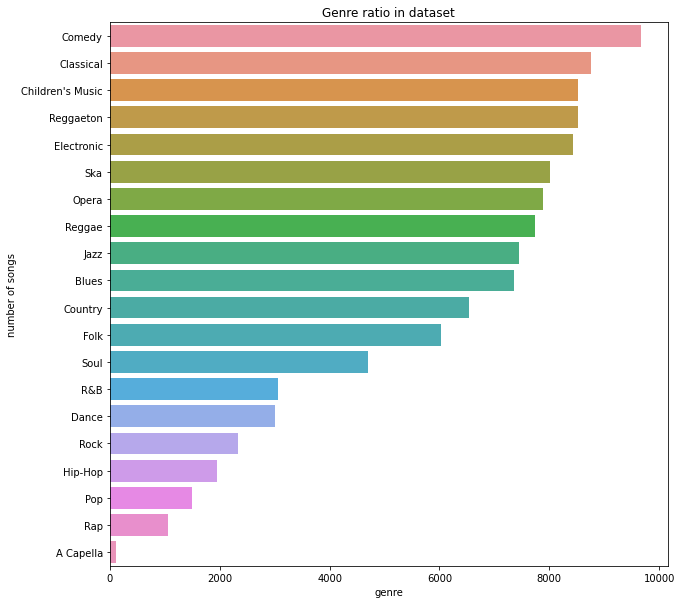

In [42]:
stdf.genre.value_counts()
plt.figure(figsize=(10,10))
sns.barplot(x=stdf.genre.value_counts().values, y=stdf.genre.value_counts().index)
plt.title('Genre ratio in dataset')
plt.xlabel('genre')
plt.ylabel('number of songs')
plt.show()

> **⏭ Result**<br>
일부 장르를 제거하고,  다중타겟값을 가지는 데이터를 분리하고 난 뒤 얻어진<br>
데이터프레임 stdf는 하나의 장르만을 가지는 대신 classweight가 균형 있지는 않음.<br>

>상대적으로 대중에게 익숙한 장르들의 데이터가 줄어들었음<br>
  → 대중에게 익숙한 장르가 Mixed genre에 포함되기 쉬움<br>
  → 대부분 익숙한 장르를 베이스로 믹스되는것을 알 수 있음.<br>
  → 거의 모든 A Capella 곡이 복합장르로 분류되어있었음을 알 수 있음.

> **💡 Decision**  
> - **음악적 요소와 관계없는 특성 drop** <br>
→ 'artist_name', 'track_name', 'popularity', 'duration_ms', 'track_id'

In [43]:
st_data = stdf.drop(columns = ['artist_name', 'track_name', 'popularity', 'duration_ms', 'track_id'])

In [44]:
mt_data = mtdf.drop(columns = ['artist_name', 'track_name', 'popularity', 'duration_ms', 'track_id'])

In [45]:
st_data.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,112661.0,0.416155,0.371211,0.000001,0.0490,0.304000,0.8120,0.996
danceability,112661.0,0.557186,0.184467,0.058200,0.4350,0.573000,0.6960,0.989
energy,112661.0,0.570593,0.277956,0.000020,0.3620,0.616000,0.8050,0.999
instrumentalness,112661.0,0.151195,0.301228,0.000000,0.0000,0.000066,0.0525,0.997
liveness,112661.0,0.242384,0.231075,0.010200,0.0977,0.135000,0.3030,1.000
loudness,112661.0,-10.145638,6.376337,-47.599000,-12.8390,-8.213000,-5.6330,3.744
speechiness,112661.0,0.151899,0.240269,0.022200,0.0383,0.053200,0.1190,0.967
tempo,112661.0,116.765342,31.402455,32.451000,91.8690,113.808000,137.9590,242.903
valence,112661.0,0.480060,0.266572,0.000000,0.2570,0.479000,0.6980,1.000


> **💡 Decision**  
> - **Normalization** <br>
→ loudness, tempo 두 특성을 제외하면 일반화 되어있음.<br>
> - **MinMaxScaler** <br>
→ 상기한 두 특성과 나머지 특성의 스케일의 차이는 큼<br>
→ 템포는 시분할된 수치이므로 분포와 아주 민감한 관계임. 즉 분포에 변동이 생기지 않는 MinMaxScaler 사용 <br>
→ 합리적인 범위 내의 tempo 값으로, 이상치가 없으므로 이상치에는 민감한 minmaxscaler도 사용가능



> **⏭ EDA Result**<br>
Multiclass Classification으로 해결해야함(다중분류문제)<br>
MinMaxScaler로 특성간 scale 차이에 영향받지않게 함<br>
Tree based인 XGBoost로 학습시킴(multi:softmax)

## **1-3. Dataset split**
> ⚠️***장르가 하나인 st_data로 학습.***<br>
> ⚠️***학습 데이터셋과 테스트 데이터셋 분리.***

In [46]:
target = "genre"

In [47]:
X = st_data[st_data.columns.difference([target], sort = False)]
y = st_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90128, 12) (90128,)
(22533, 12) (22533,)


# **Part 2. Data Analysis**

<img width='500' src='https://www.enerdata.co.kr/sites/default/files/images/market-analysis.jpg'>


## **2-0. Modeling**


> **💡 Decision**  
> - **Model - XGBoost** <br>
타겟의 종류가 많아서 다중분류문제로 풀어야 함(multi:softmax) <br>

> - **target/sample unbalance** <br>
타겟의 샘플갯수가 불균형해서 가중치를 줌
 - sample_weight
 - class_weight

In [49]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train.values
)

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90128 entries, 172581 to 42617
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      90128 non-null  float64
 1   danceability      90128 non-null  float64
 2   energy            90128 non-null  float64
 3   instrumentalness  90128 non-null  float64
 4   key               90128 non-null  object 
 5   liveness          90128 non-null  float64
 6   loudness          90128 non-null  float64
 7   mode              90128 non-null  object 
 8   speechiness       90128 non-null  float64
 9   tempo             90128 non-null  float64
 10  time_signature    90128 non-null  object 
 11  valence           90128 non-null  float64
dtypes: float64(9), object(3)
memory usage: 8.9+ MB


In [66]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [67]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [83]:
params = {'xgbclassifier__min_child_weight': [16, 18, 20],
          'xgbclassifier__gamma': [3, 4, 5],
          'xgbclassifier__max_depth': [4, 5, 6, 7]} 

pipeline = make_pipeline(
    OrdinalEncoder(),
    MinMaxScaler(),
    XGBClassifier(
        objective='multi:softmax',
        n_estimators=40,
        random_state=42,
        learning_rate=0.2,
        eval_metric = 'merror', 
        n_jobs=10,
        class_weight=classes_weights,
        use_label_encoder=False)
    )


clf = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    scoring='f1_micro', 
    n_iter = 5,
    cv = 3,
    verbose=1,
    n_jobs =-1,
    random_state=42
    )

# f1_Micro : f1 스코어의 평균을 계산할 때 각 클래스의 샘플 수를 고려하여 평균을 취하는 방식 
# f1_Macro : f1 스코어의 평균을 계산할 때 각 클래스의 샘플 수에 상관없이 평균을 취하는 방식

In [69]:
labelencoder = LabelEncoder()
y_train_enc = labelencoder.fit_transform(y_train)
y_test_enc = labelencoder.transform(y_test)
labelencodermap = list(labelencoder.inverse_transform(list(range(20))))

> - **타겟에 대해 라벨 인코딩** <br>
→ XGB의 다중레이블 접근은 0부터 클래스 갯수 -1개 까지의 정수임<br>
→ dance : 1 / rnb : 2 / ballad : 3 / pop : 4 / hiphop : 5 / rock : 6 

## **2-1. Learning**
> ⚠️***RandomizedSearchCV를 통해 최적의 HP생성***

In [84]:
clf.fit(X_train, y_train_enc)
print("Optimal Hyperparameter:", clf.best_params_)
print("f1_micro:", clf.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[09:07:34] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Optimal Hyperparameter: {'xgbclassifier__min_child_weight': 20, 'xgbclassifier__max_depth': 7, 'xgbclassifier__gamma': 5}
f1_micro: 0.5047376896316723


In [85]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,0,3,4,1,2
mean_fit_time,133.367554,113.822075,91.297354,72.019649,72.357749
std_fit_time,0.762368,0.312938,2.605824,0.757752,0.91252
mean_score_time,0.978049,0.955613,0.678377,0.632476,0.644147
std_score_time,0.026848,0.019768,0.170033,0.034518,0.02202
param_xgbclassifier__min_child_weight,20,16,18,18,20
param_xgbclassifier__max_depth,7,6,5,4,4
param_xgbclassifier__gamma,5,5,4,4,5
params,"{'xgbclassifier__min_child_weight': 20, 'xgbcl...","{'xgbclassifier__min_child_weight': 16, 'xgbcl...","{'xgbclassifier__min_child_weight': 18, 'xgbcl...","{'xgbclassifier__min_child_weight': 18, 'xgbcl...","{'xgbclassifier__min_child_weight': 20, 'xgbcl..."
split0_test_score,0.507473,0.504843,0.502446,0.494558,0.494857
split1_test_score,0.503512,0.502513,0.499784,0.493692,0.493459


In [86]:
model = clf.best_estimator_ # 최적의 param을 가지는 모델

In [87]:
model.fit(X_train, y_train_enc)

[09:09:20] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key', 'mode', 'time_signature'],
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': F#      1
D#      2
A       3
D       4
A#      5
B       6
F       7
G       8
E       9
C#     10
C      11
G#     12
NaN    -2
dtype: int64},
                                         {'col': 'mode',
                                          'data_type': dtype('O'),
                                          'mapping': Major    1
Minor    2
NaN     -2
dtype: int64},
                                         {'col': 'time_signature',
                                          'data_type': dtype('O'),
                                          'mapping': 5/4    1
3/4    2
4/4    3
1/4    4
0/4    5
NaN   -2...
                               gamma=5, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_cons

In [88]:
baseline = pd.Series(y_train).mode()
y_pred_base = [baseline] * len(y_train)
print('기준모델 score: {}'.format(round(f1_score(y_train, y_pred_base, average = 'micro'),2)))

기준모델 score: 0.09


> **⏭ EDA Result**<br>
기준모델(0.09)에 비해 XGBoost(0.51)높긴 하지만, 차이가 너무 큰 것 같음. <br>
23개의 멀티클래스를 분류 기준모델의 성능을 최빈값을 가지는 단일클래스로 설정해서 기준모델의 성능이 너무 낮았고, <br>
고등 분류모델에 하이퍼파라미터를 설정한 XGBoost가 월등히 높은건 당연한것 같음.<br>
23개의 멀티클래스에 대해 score가 0.51 나오는거면 충분히 높다고 생각해서 모델설정 마무리함.

## **2-1. Predict**
> ⚠️***RandomizedSearchCV를 통해 최적의 HP생성***

In [89]:
X_test_pred = model.predict(X_test)
print('테스트 score: {}'.format(round(f1_score(y_test_enc, X_test_pred, average = 'micro'),2)))

테스트 score: 0.51


In [91]:
from sklearn.metrics import classification_report

print("Test  Accuracy : %.2f"%model.score(X_test, y_test_enc))
print("Classification Report")
print(classification_report(y_test_enc, model.predict(X_test)))

Test  Accuracy : 0.51
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.11      0.18        18
           1       0.32      0.35      0.33      1453
           2       0.49      0.40      0.44      1709
           3       0.70      0.69      0.69      1791
           4       0.96      0.94      0.95      1964
           5       0.39      0.57      0.46      1334
           6       0.23      0.10      0.14       599
           7       0.57      0.66      0.61      1709
           8       0.33      0.35      0.34      1213
           9       0.33      0.21      0.26       385
          10       0.43      0.42      0.42      1452
          11       0.69      0.74      0.71      1589
          12       0.50      0.03      0.06       308
          13       0.26      0.18      0.21       621
          14       0.21      0.01      0.03       212
          15       0.42      0.47      0.44      1572
          16       0.46      0.69    

Text(0.5, 1.0, 'Extended Confusion Matrix')

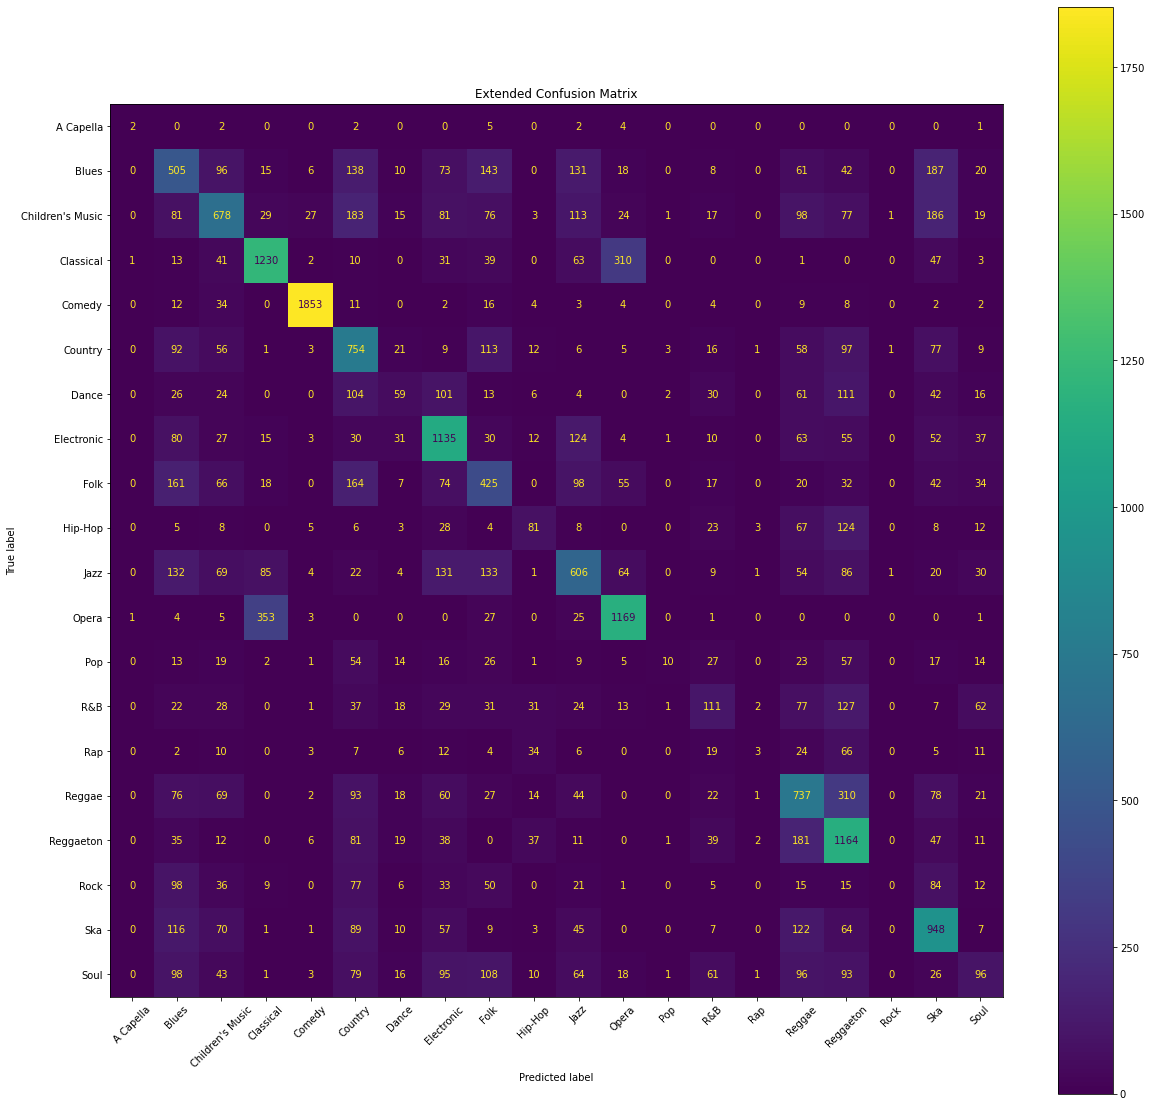

In [94]:
label = list(range(20))
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
fig, ax = plt.subplots(figsize=(20,20))
plot = plot_confusion_matrix(model,
                             X_test, 
                             y_test_enc,
                             ax=ax,
                             display_labels=labelencodermap,
                             normalize=None)
plt.xticks(rotation=45)
plot.ax_.set_title('Extended Confusion Matrix')

> **⏭ EDA Result**<br>
→ pop, rap 등 표본이 적은 타겟은 잘 못맞춤<br>
→ reggae, geggaeton 유사장르간 FN,FP가 높게나옴(분류의 어려움을 겪음)

Feature[0]:acousticness, Score: 0.1333
Feature[1]:danceability, Score: 0.0988
Feature[2]:energy, Score: 0.0852
Feature[3]:instrumentalness, Score: 0.1125
Feature[4]:key, Score: 0.0226
Feature[5]:liveness, Score: 0.0305
Feature[6]:loudness, Score: 0.1155
Feature[7]:mode, Score: 0.0626
Feature[8]:speechiness, Score: 0.2093
Feature[9]:tempo, Score: 0.0463
Feature[10]:time_signature, Score: 0.0255
Feature[11]:valence, Score: 0.0579


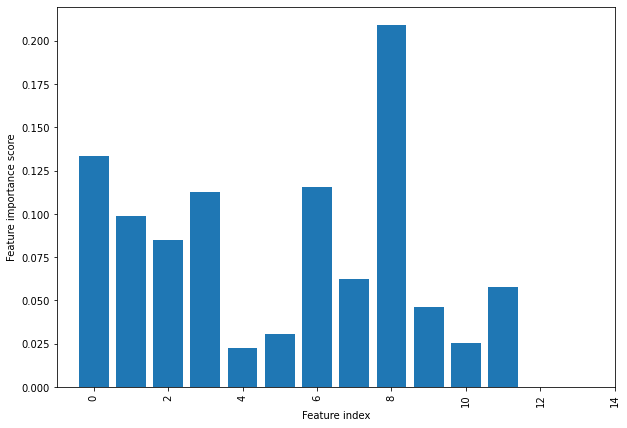

In [93]:
importance = model.named_steps['xgbclassifier'].feature_importances_

for i,v in enumerate(importance):
    print('Feature[%0d]:%s, Score: %.4f' % (i,X_test.columns[i],v))
    
plt.subplots(figsize=(10,7))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature index')
plt.ylabel('Feature importance score')
plt.xticks(rotation=90)
plt.xticks(np.arange(0,len(df.columns)-2, 2.0))
plt.show()

> **⏭ EDA Result**<br>
기준모델(0.09)에 비해 XGBoost(0.51)높긴 하지만, 차이가 너무 큰 것 같음. <br>
23개의 멀티클래스를 분류 기준모델의 성능을 최빈값을 가지는 단일클래스로 설정해서 기준모델의 성능이 너무 낮았고, <br>
고등 분류모델에 하이퍼파라미터를 설정한 XGBoost가 월등히 높은건 당연한것 같음.<br>
23개의 멀티클래스에 대해 score가 0.51 나오는거면 충분히 높다고 생각해서 모델설정 마무리함.

> **⏭ EDA Result**<br>
[여기](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 에 따르면 Multi-class classification의 feature importance는 <br>각 target마다 얻게되는 feature importance의 평균으로 반환됨.<br>
즉 타겟 분류에 있어서 전체적으로 중요도가 높은 특성은 <br>
<U>**Feature[8] : speechiness, Score: 0.2116**</U> **'speechiness'** 특성이라고 할 수 있음.<br>
이후 **acousticness, loudness, instrumentalness** 순

## **Q4. ⚡Generalization⚡**
 **<h4><b> 두 Publisher의 선호장르는 슈팅, 액션, 스포츠이며 공통적으로 슈팅게임을 선호한다.</b></h4>**

# **Part 3. Questions & Insight**

<img width='500' src='https://storylytics.ca/wp-content/uploads/2020/12/define-insight.png'>

## **2-1. Questions & Insight**

`business questions:`
- **Q1. 음원의 어떤 성분이 장르를 결정짓는가** <br>


> **A1.**<br>
특성중요도에 따르면,
**</U>'speechiness'** 가장 중요한 성분은 특성이라고 할 수 있음.<br>
이후 **acousticness, loudness, instrumentalness** 순으로
 대체로 추상적이지않고 <br>수치화 시킬 수 있는 음악적 요소라는 점에서 음악적 성분에 따라 장르를 분류할 수 있다고 할 수 있음.<br>
 
 >**Reference**<br>
 speechiness(보컬세션의 참여시간)<br>
 acousticness(전자음향이 적은 정도)<br>
 loudness(곡의 음량 dB(데시벨)) <br>
 instrumentalness(보컬의 음량비중)<br>

- **Q2. 음원의 특성으로 장르를 제대로 분류할 수 있는가?**<br>
  - 사람이 구분한 장르에 기준을 매길 수 있을까? ⭕<br>
  - 장르와 음악성분을 기반으로 분류한 클러스터의 군집도가 유사한가? <br>

> **A2.**<br>
23개의 라벨에 대해 기준모델(baseline)의 F1스코어가 0.09로, XGBoost 모델의 F1스코어가 0.51이 나왔음.<br>
F1 스코어는 정밀도와 재현률의 조화평균으로 나오는 점수인만큼, 정밀도와 재현률 둘다 높은편으로, <br>비트맵으로 구현된 확장혼동행렬상으로 보기에도 일부 타겟을 제외하면 꽤 높은 비율로 분류되고 있음을 알 수 있음.

> **add**<br>
클러스터링을 통해 코사인유사도로 장르를 분류하는 모델을 만들고 기준모델로 삼아서 비교하려했으나 <br>여러가지 시행착오 때문에 시간이 없어서 시도하지못했음.

- **Q3. 음원추천**<br>
  - 코사인 유사도(클러스터링)와 장르를 통한 음원추천 

> **A3.**<br>
시간이 없어서 시도하지못했음.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## **0. Reflection and Feedback**

<img width='500' src='https://tbc.imgdl.xcache.kinxcdn.com/cdn001/20191205/60933532_1206_peng_2.jpg'>

# **Points**
####**1. 시간제한 있는 프로젝트에 안배운거 시도하지 말자**
####**2. 데이터를 만들고 가공하려고 애쓰지마라. 데이터는 찾아보면 다 있다.**

> **🔧 this project**<br>
→ XGB에 class_weight를 사용할 수 없음.<br>
(이진분류에만 사용할 수 있다는 글이 많이 나옴)<br>
→ 기준모델을 적어도 기본적인 클러스터링 모델을 통해 의미있는 수준의 score를 냈어야 했었지않나.<br>
→ 다양한 모델에 적용해봤어야하는데...(그저 새로운거 시도하고 허튼짓하느라 낭비한 시간의 문제)<br>
→ eli5.show_weights를 각 label별 feature importance가 나오도록 설정하는것에서 문제를 겪음<br>
  (검색해보니 방법은 있는 것 같은데 무수히 많은 오류가 반겨줌<br>
→ PDP/ICE Plot 못그려봄. 멀티클래스 분류문제(전 특성/타겟별)에서 proba를 지원하지않음. <br>(아마 결과를 튜플형식으로 반환하는게 아닐거같다는 생각. 멀티타겟분류는 전반적으로 좀더 공부하고나서 써야할 것 같음)<br>
→ keras library, Softmax Regression을 배우고 난 후 다중타겟으로 적용해보기<br>
→ 타겟을 여러개 가지는 데이터(이번에 못써본) 분석 다음에 꼭 해보기<br>

> **🔧 next project**<br>
→ ○더 많은 음원데이터 획득 필요성 체감(2100곡은 너무 적다)<br>
→ ○크롤링 제대로 배워서 꼭 타겟 채워보기<br>
→ ○평균, 분산 외에도 다양한 방법으로 파형 특성추출 시도 필요<br>(현재 데이터는 너무 단조로운 특성추출임)<br>
→ ○특성추출중 차원을 줄이는 과정(magnitude, scale, phase 3차원 파형에서 단일값(1dim)+분산으로 축소)에서 많은 파형특성을 잃음. 파형특성을 최대한 반영하기 위해 librosa library 함수들을 더 공부할 필요 있음